In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import esmtools as et
from esmtools import stats

import shapefile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gp
import regionmask
import matplotlib.patches as mpatches

In [2]:
# Open dataset 
dir = '/home/jovyan/SOARS_2021/Data/MRI-ESM2-0/'
fn = 'tos_Omon_MRI-ESM2-0_omip2_r1i1p1f1_gr_165301-201812.nc'

data_tos = xr.open_dataset(dir+fn)
data_tos

/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/xarray/core/indexing.py:572: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 360, time: 4392)
Coordinates:
  * time       (time) object 1653-01-16 12:00:00 ... 2018-12-16 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tos        (time, lat, lon) float32 ...
Attributes: (12/36)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           OMIP
    branch_method:         no parent
    creation_date:         2020-03-26T15:26:15Z
    data_specs_version:    01.00.31
    experiment:            OMIP experiment forced by JRA55-do atmospheric dat...
    ...                    ...
    title:                 MRI-ESM2-0 output prepared for CMIP6
    variable_id:           tos
    variant_label:         r1i1p1f1
    license:               CMIP6 model data produced by MRI is licensed under...
    cmor_version:          3.5.0
    tracking_id:           hdl:21.14100/8fdc222c-7031-46f7-8434-2bd763e70019

In [3]:
# Change the time to be from DatetimeNoLeap to a Datetime64
#data_tos['time'] = np.arange('1653-01-01','2018-12-16',dtype = 'datetime64[M]')
#data_tos

In [4]:
# select dimensions!
#data_tos['time'] = pd.date_range("1653-01", "2018-12", freq="MS")
tos = data_tos['tos']
tos = tos.sel(lon=slice(190,270),lat=slice(-10,70))
print(tos)

<xarray.DataArray 'tos' (time: 4392, lat: 80, lon: 80)>
[28108800 values with dtype=float32]
Coordinates:
  * time     (time) object 1653-01-16 12:00:00 ... 2018-12-16 12:00:00
  * lat      (lat) float64 -9.5 -8.5 -7.5 -6.5 -5.5 ... 65.5 66.5 67.5 68.5 69.5
  * lon      (lon) float64 190.5 191.5 192.5 193.5 ... 266.5 267.5 268.5 269.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2020-03-26T15:26:15Z altered by CMOR: replaced missing va...


In [5]:
# remove long term trend for each grid cell
var = stats.rm_poly(tos,order=2,dim='time',nan_policy='drop')

In [6]:
# 1982-2010 period
base = var.sel(time=slice('1982-01','2010-12'))
tos_base = base

In [7]:
# Blob period
blob = var.sel(time=slice('2013-07','2016-06'))
tos_blob = blob

In [8]:
# Difference between the two periods
blob_anom = blob.groupby('time.month') - base.groupby('time.month').mean()

In [9]:
# Resample to two month resolution
cesm = blob_anom.resample(time='2M').mean()
cesm

<xarray.DataArray (lat: 80, lon: 80, time: 19)>
array([[[ 7.64615684e-02,  1.35352412e-01, -8.54208862e-02, ...,
          7.21742668e-01,  6.91872717e-01,  3.96567473e-01],
        [ 6.50100477e-02,  1.06506064e-01, -7.77977597e-02, ...,
          7.47980378e-01,  7.42477560e-01,  4.27838415e-01],
        [ 4.70650503e-02,  8.10923791e-02, -6.79977162e-02, ...,
          7.77639495e-01,  7.90646569e-01,  4.82772326e-01],
        ...,
        [-5.71792900e-01, -5.16968591e-01, -5.34386491e-01, ...,
          7.15797409e-01,  9.01354435e-01,  1.26791194e+00],
        [-5.77920158e-01, -5.21425095e-01, -5.62847847e-01, ...,
          6.64366569e-01,  9.19542830e-01,  1.25931536e+00],
        [-5.85163867e-01, -5.29903567e-01, -5.92660543e-01, ...,
          6.27729590e-01,  9.35173757e-01,  1.26058151e+00]],

       [[ 7.62944778e-02,  1.57478455e-01,  7.33146697e-02, ...,
          7.82978792e-01,  7.88859668e-01,  5.30787606e-01],
        [ 7.19919466e-02,  1.36053841e-01,  9.52872431e-02, ...,
          7.92282499e-01,  8.38189503e-01,  5.50548306e-01],
        [ 5.88856092e-02,  1.18932549e-01,  1.23295614e-01, ...,
          8.21098865e-01,  8.80014833e-01,  5.73691074e-01],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-2.52458720e-01, -5.49888440e-01,  4.71243072e-02, ...,
         -1.00779976e-02, -8.42913483e-03,  5.09208173e-03]],

       [[-5.48798961e-01, -3.37490472e-01,  1.39161959e-01, ...,
         -1.19636073e-02,  1.98435624e-02, -2.93353463e-01],
        [-4.23575305e-01, -4.20251612e-01,  2.65677169e-01, ...,
         -1.11973618e-02,  2.51518489e-02, -2.12860525e-01],
        [-4.49339266e-01, -5.06436587e-01,  4.24005479e-01, ...,
         -1.09851461e-02,  2.82276779e-02, -4.39506095e-02],
        ...,
        [-1.87238217e-01, -3.89600764e-01,  5.27699852e-02, ...,
         -3.12647760e-03, -1.61567967e-03, -7.80443177e-03],
        [-1.49134248e-01, -3.36570451e-01,  5.04192982e-02, ...,
         -3.01656919e-03, -1.67156262e-03, -2.96779357e-03],
        [-1.50232351e-01, -3.40290437e-01,  3.39281572e-02, ...,
         -4.25566898e-03, -3.90455556e-03,  2.36422868e-03]]])
Coordinates:
  * time     (time) object 2013-07-31 00:00:00 ... 2016-07-31 00:00:00
  * lat      (lat) float64 -9.5 -8.5 -7.5 -6.5 -5.5 ... 65.5 66.5 67.5 68.5 69.5
  * lon      (lon) float64 190.5 191.5 192.5 193.5 ... 266.5 267.5 268.5 269.5

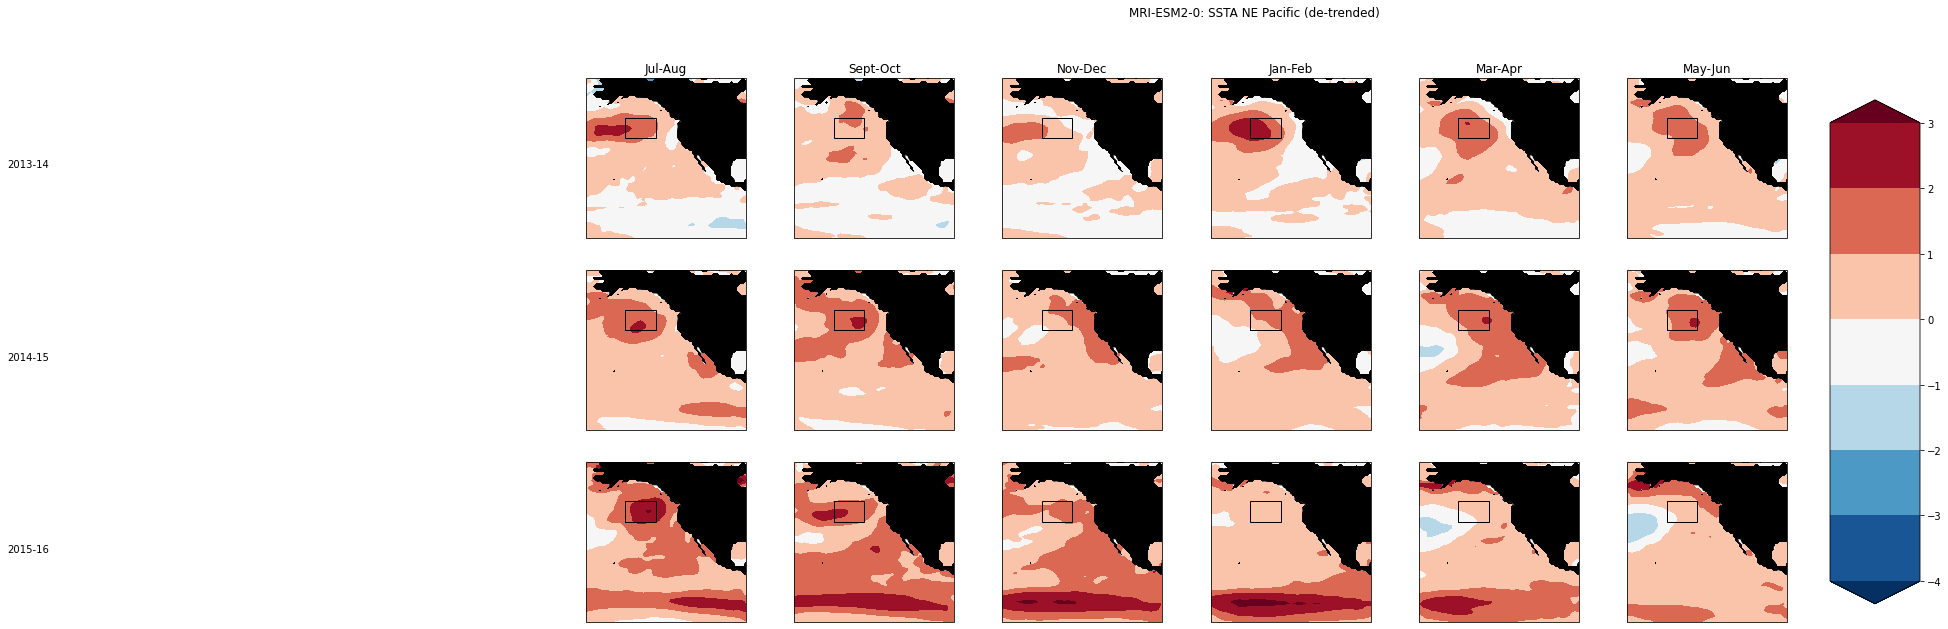

In [10]:
def panels(data,description,variable,depth,lower_bound,upper_bound, step,cmap):
    f, axs = plt.subplots(nrows=3,ncols=6,figsize=(25,10),
                          subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))) 
    axs = axs.flatten()
    for i in range(0,18):
        im = axs[i].contourf(cesm.lon, cesm.lat, cesm.isel(time=i),
                         transform=ccrs.PlateCarree(), 
                         cmap=cmap,
                         levels=np.arange(lower_bound, upper_bound, step),
                         extend='both')
        axs[i].add_feature(cfeature.LAND, color='k')
        axs[i].add_patch(mpatches.Rectangle(xy=[210, 40], width=15, height=10,
                                    edgecolor='k',
                                    facecolor='none',
                                    transform=ccrs.PlateCarree())
                 )
    plt.suptitle("MRI-ESM2-0: " + description + " " + variable + " " + depth + " (de-trended)")
    axs[0].set_title("Jul-Aug"); axs[1].set_title("Sept-Oct")
    axs[2].set_title("Nov-Dec"); axs[3].set_title("Jan-Feb")
    axs[4].set_title("Mar-Apr"); axs[5].set_title("May-Jun")
    plt.text(-790,215,'2013-14')
    plt.text(-790,120,'2014-15')
    plt.text(-790,25,'2015-16')
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.82, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax,fraction=0.046,pad=0.04)
    
panels(tos,'SSTA','NE','Pacific',-4.0,4.0, 1.0,'RdBu_r')